# LTKHDL - Final Project

(Cập nhật lần cuối: 19/1/2022)
<h3> Thành viên nhóm: </h3>
 - Nguyễn Tuấn Anh - 18120110 <br>
 - Chương Việt Hoàng - 18120124 <br>
 - Lê Thị Tuyết Trinh - 18120616 <br>
 <h3> Link tới thùng chứa Github: </h3>
 <a href = "https://github.com/trinh172/LTKHDL_DACK"> Final Project </a>


---

## Môi trường code

In [1]:
import sys
sys.executable

'/home/cvh/anaconda3/envs/min_ds-env/bin/python'

Nếu không có vấn đề gì thì file chạy python sẽ là file của môi trường code "min_ds-env".

## Cài đặt các thư viện cần thiết

In [2]:
%%capture
!pip install underthesea
!pip install tqdm
!pip install wordcloud

---

## Import các thư viện cần thiết

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

from underthesea import word_tokenize
import unidecode
import string
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import copy

---

## Thu thập dữ liệu

Trong đồ án này, nhóm em sửa dụng dữ liệu đã được thu thập sẵn là file "review_mbbank.csv" đính kèm; đây là dữ liệu về đánh giá của người dùng về app MB Bank. Dữ liệu này được crawl từ Google Play.

---

## Khám phá dữ liệu

### Đọc dữ liệu từ file csv vào dataframe

In [4]:
df_review = pd.read_csv('review_mbbank.csv')
df_review

,ID,reviewer,content,date_time,rate
0,0,Lew Lew,"MB cái gì cũng được, trừ cái otp ngu ngốc, mỗi...",18-07-21 18:34,3
1,1,Đạt Nguyễn Js,Giới thiệu rồi có thông báo rồi mà ko nhận đc ...,14-07-21 18:08,1
2,2,ha duc,App đòi quản lý nhiều quá,13-07-21 8:49,1
3,3,Thịnh Hà,Chẳng nhận được 30k và 1k điểm khi được giới t...,11-11-21 18:56,4
4,4,Deee Yuuu,tốt,22-06-21 18:31,5
...,...,...,...,...,...
13894,13894,yen ho,Ứng dụng dì mà được thưởng mà ko nhận được,19-03-21 22:28,2
13895,13895,Nhân Nguyễn Thành Nhân,Tốt cho 5 sao luôn,10-03-21 15:35,5
13896,13896,Chieu Thien,Rất tốt. Riêng e cảm nhận thì chuyển tiền hay ...,23-09-21 9:49,5
13897,13897,Tuấn Lê,Cập nhật xong thì k vào đc ứng dụng nữa. Ứng d...,27-07-21 23:05,1


### Dữ liệu gồm có bao nhiêu dòng và bao nhiêu cột?

Tính số dòng và số cột (không được code cứng con số) và lần lượt lưu vào 2 biến là `num_rows` và `num_cols`. 

In [5]:
df_review.shape

(13899, 5)

### Mỗi dòng có ý nghĩa gì? Có vấn đề các dòng có ý nghĩa khác nhau không?

Đây là dữ liệu được crawl từ bên Google Play về với nội dung là review của khách hàng nên nhóm em nghĩ sẽ có nhiều vấn đề ví dụ như bị trùng lặp dữ liệu, kiểu dữ liệu,...

### Có gì đó bị lặp không ...

In [6]:
#Kiểm tra trùng lắp dữ liệu
have_duplicated_rows = df_review.duplicated().any()
print(have_duplicated_rows)

#Kiểm tra trùng lắp user
have_duplicated_reviewer = len(set(df_review['reviewer']))/df_review.shape[0]
print(have_duplicated_reviewer)

False
0.8876178142312396


Từ kết quả này, nhóm thấy rằng dữ liệu không bị lặp, điều này dễ hiểu vì cơ sở dữ liệu mà nhóm xây dựng có trường ID là primary key. Tuy nhiên tỉ lệ user khác nhau chỉ có 88,76%, nghĩa là có 12,66% user trùng tên bình luận. Từ đây kết luận 3 trường hợp sau có thể xảy ra:

1. Có những user trùng nickname google play.
2. Một user spam bình luận nhiều lần (mục đích kéo rate lên/xuống).
3. Một user bình luận góp ý nhiều lần.

Những phần sau, nhóm có thể sẽ tìm hiểu dữ liệu để đưa ra kết luận tốt hơn những trường hợp này.

### Mỗi cột có ý nghĩa gì?

Dưới đây là phần mô tả của dữ liệu:
- **ID**: a unique identifier for each observation.
- **reviewer**: the account's name.
- **content**: the content of reviewer.
- **date_time**: date the reviewer take review.
- **rate**: rating of reviewer for app.

### Mỗi cột hiện đang có kiểu dữ liệu gì? Có cột nào có kiểu dữ liệu chưa phù hợp để có thể xử lý tiếp không?

Nhóm lấy `dtype` (kiểu dữ liệu của mỗi phần tử) của mỗi cột trong `df_review` và lưu kết quả vào series `col_dtypes`; series này có index là tên cột. 

In [7]:
col_dtypes = df_review.dtypes
print(col_dtypes)

ID            int64
reviewer     object
content      object
date_time    object
rate          int64
dtype: object


**Cột có dtype là object nghĩa là sao?**

`df_review` có 3 cột có `dtype` là `object`: reviewer, content, date_time.
Nhóm viết hàm nhận đầu vào là một cột `s` (series) có `dtype` là `object` và trả về tập các kiểu dữ liệu thật sự có trong cột này. (Sử dụng series.apply())

In [8]:
def open_object_dtype(s):
    dtypes = set()
    col = pd.Series(s)
    result = col.apply(type)
    dtypes = set(result)
    return dtypes
print(open_object_dtype(df_review['reviewer']))
print(open_object_dtype(df_review['content']))
print(open_object_dtype(df_review['date_time']))

{<class 'str'>}
{<class 'str'>}
{<class 'str'>}


**Vấn đề cần tiền xử lý:**

- Cột "date_time" đang có dtype là `str`. Để có thể tiếp tục khám phá thêm về cột này, ta sẽ thực hiện bước tiền xử lý là chuyển sang dạng `datetime`.
- Cột "content" đang có dtype là `str`, cần kiểm tra xem có dòng content nào là chuỗi rỗng không (vì đánh giá trên google play người dùng có thể nhập chuỗi gồm các khoảng trắng và submit được).
- Cột "reviewer" đang có dtype là `str`, có lẽ cột này không có giá trị rỗng nào

---

## Tiền xử lý

### Chuyển dtype của cột "date_time" sang datetime

Nhóm em chuyển `dtype` của cột "date_time" sang kiểu dữ liệu thời gian (sau khi làm xong thì cột "date_time" trong `df_review` phải thay đổi `dtype`). Nhóm em dùng câu lệnh `pd.to_datetime`; khi dùng `pd.to_datetime`, bạn truyền giá trị phù hợp cho tham số `format` (nếu không thì sẽ chạy rất chậm vì Pandas phải đoán format).

In [9]:
df_review['date_time'] = pd.to_datetime(df_review['date_time'], format="%d-%m-%y %H:%M")
assert df_review['date_time'].dt.year.min() == 2021 

### Chuyển các giá trị chuỗi trống (chỉ chứa khoảng trắng) sang NaN

Nhóm chuyển các giá trị trống (nếu có) của cột "content" sang NaN, vì thực tế người dùng khi đánh giá app có thể nhập chuỗi trống vào và gửi bình luận được.

In [15]:
#replace all string " " in column District and CommunityArea
df_review['content'] = df_review['content'].replace(r'^\s+$', np.nan, regex=True)
print(df_review['content'].isna().sum())

0


Từ kết quả này, nhóm kết luận mọi người dùng đều không gửi bình luận rỗng. Sau đây, nhóm sẽ thực hiên khám phá dữ liệu và trả lời các câu hỏi có ý nghĩa.

### Phân tích năm 

In [16]:
col_year = df_review['date_time'].dt.year
col_year = set(col_year)
print(col_year)

{2021}


Review chỉ được thu thập trong năm 2021. Trong quá trình thu thập dữ liệu, nhóm đã chủ động chỉ thu nhập dữ liệu trong năm gần nhất, nhóm cho rằng cần phân tích dữ liệu gần nhất để doanh nghiệp (cụ thể là Ngân hàng quân đội MB Bank) đưa ra quyết định chính xác hơn.

### Thêm cột "Month" vào dataframe

In [17]:
df_review['Month'] = df_review['date_time'].dt.month
df_review.head()

,ID,reviewer,content,date_time,rate,Month
0,0,Lew Lew,"MB cái gì cũng được, trừ cái otp ngu ngốc, mỗi...",2021-07-18 18:34:00,3,7
1,1,Đạt Nguyễn Js,Giới thiệu rồi có thông báo rồi mà ko nhận đc ...,2021-07-14 18:08:00,1,7
2,2,ha duc,App đòi quản lý nhiều quá,2021-07-13 08:49:00,1,7
3,3,Thịnh Hà,Chẳng nhận được 30k và 1k điểm khi được giới t...,2021-11-11 18:56:00,4,11
4,4,Deee Yuuu,tốt,2021-06-22 18:31:00,5,6


---

## Khám phá dữ liệu 

### Trong cột rate, số lượng mỗi điểm là bao nhiêu?

Cột rate chứa điểm số mà người dùng đánh giá cho app, viết hàm để tính số lượng từng điểm (1 - 5) và vẽ biểu đồ

1    6699
2     736
3     686
4     647
5    5131
Name: rate, dtype: int64


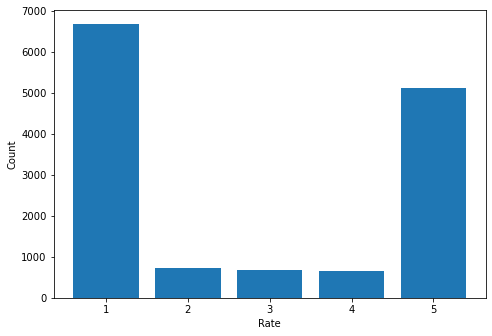

In [18]:
rate_count = df_review['rate'].value_counts()
rate_count = rate_count.sort_index()
print(rate_count)

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(rate_count.index,rate_count)
ax.set_xlabel("Rate")
ax.set_ylabel("Count")
plt.show()

Nhìn biểu đồ có thể thấy số lượt rate 1 sao và 5 sao cho app là chiếm đa số, trong đó app bị rate 1 sao nhiều nhất (6699 người đánh giá 1 sao). Ngoài ra lượt rate 2, 3, 4 khá là giống phân phối đều, điều này có thể kết luận tương đối rằng user đánh giá mức sao 2, 3, 4 khá ngẫu nhiên. Từ những điều trên, trong quá trình phân tích, nhóm sẽ xem xét bỏ qua lượt rate 2, 3, 4 sao.

### Reviewer review bao nhiêu lần?

1     11518
2       539
3       143
4        50
5        22
6        17
7        12
8         9
9         8
10        4
11        5
12        1
13        2
14        4
15        3
Name: reviewer, dtype: int64


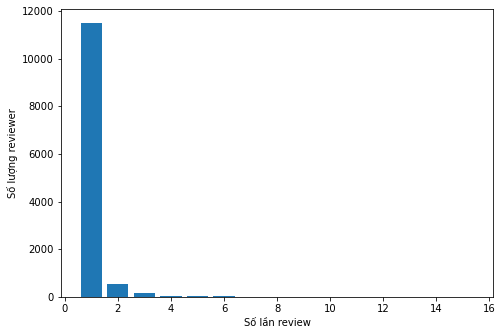

In [19]:
review_count = df_review['reviewer'].value_counts()
review_count = review_count.value_counts()
review_count = review_count.sort_index()
print(review_count)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_xlabel("Số lần review")
ax.set_ylabel("Số lượng reviewer")
ax.bar(review_count.index,review_count)
plt.show()

Ta có thể thấy phần lớn reviewer chỉ review 1 lần. Số lần review của reviewer giảm dần.

### Rating trung bình theo số lần reviewer review?

    count      rate
0       1  2.770794
1       2  2.721707
2       3  2.743590
3       4  2.460000
4       5  2.800000
5       6  2.843137
6       7  2.845238
7       8  2.833333
8       9  3.027778
9      10  2.825000
10     11  2.890909
11     12  2.916667
12     13  2.307692
13     14  3.250000
14     15  3.266667


/tmp/ipykernel_159/1619486916.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['count'] = pd.DataFrame([(reviewer == x).sum() for x in reviewer], columns = ['count'])


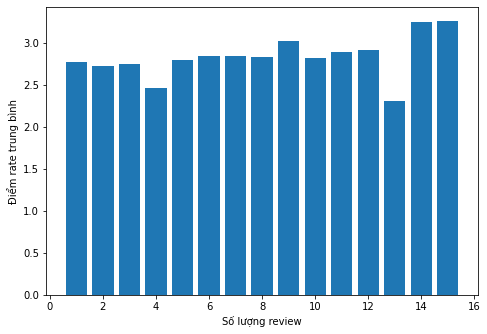

In [20]:
df = df_review[['reviewer', 'rate']]
reviewer = df['reviewer'].to_numpy()
df['count'] = pd.DataFrame([(reviewer == x).sum() for x in reviewer], columns = ['count'])
df = df[['rate', 'count']].groupby('count').mean().reset_index()

print(df)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_ylabel("Điểm rate trung bình")
ax.set_xlabel("Số lượng review")
ax.bar(df['count'],df['rate'])
plt.show()

Biểu đồ không cho thấy sự thay đổi, các reviewer review 14 và 15 lần có rating trung bình cao nhất.

### Tỷ lệ % review đúng chính tả?

Kiểm tra bằng cách check từng word trong content có nằm trong file từ vựng hay không (cách này không tối ưu nhưng cũng tương đối chính xác)

In [21]:
def func(Str):
    return all(word in vocab for word in Str.split(" "))

df = df_review['content']
vocab = np.loadtxt("vocab.txt", dtype=str, encoding='utf-8')
#content = df.to_numpy()
num_correct = df.apply(func).sum() * 100 / len(df)
print(num_correct)

1.6332110223757106


Đa số các review đều sai chính tả và viết tắt

---

## Đưa ra các câu hỏi cần trả lời

Sau khi đã khám phá dữ liệu và hiểu hơn về dữ liệu, ta thấy có một số câu hỏi có thể được trả lời bằng dữ liệu:
1. **Người ta nói gì về MB Bank ?**<br/>
Nhóm trả lời câu hỏi này để giúp doanh nghiệp lắng nghe người dùng tốt hơn để đưa ra quyết định chỉnh sửa/thay đổi app sao cho phù hợp.
2. **Phân bố rate theo tháng như thế nào?** <br/> 
Câu hỏi này nhằm giúp MB Bank có thể biết được vào các tháng (khoảng thời gian khi có thêm tính năng mới hoặc cập nhật) thì phản ứng chung của người dùng dành cho app như thế nào. Chẳng hạn tính năng giới thiệu người quen nhận thêm tiền vào tài khoản vào tháng 11, lượng review nâng cao nhất cho thấy với tính năng mới này đạt được nhiều sự chú ý của người dùng.
3. **Tìm hiểu ảnh hưởng của câu từ đến rating?** <br/>
Kiểm tra điểm mà reviewer cho app có đúng với content mà họ đã nhập không (tức là khi người dùng đánh giá 4, 5 sao nhưng content họ nhập là các từ ngữ tiêu cực thì có thể review đó là không đúng)
4. **Người ta đánh giá như thế nào về một số tính năng của MB Bank?** <br/>
Khi app MB Bank ra một tính năng gì đó chắc chắn sẽ muốn biết nhận xét tổng của khách hàng về tính năng của mình được đánh giá tốt/xấu như thế nào, từ đó sẽ cải thiện tính năng của mình cho thích hợp hơn. Việc tìm ra đánh giá của khách hàng về một số tính năng sẽ giúp cho bên MB Bank nhận ra được các lỗi cần phải sửa và nguyên nhân vì sao app của mình lại bị nhiều rate 1 sao như hiện tại.




---

## Tiền xử lý

### Các hàm tiền xử lý

In [22]:
#Lấy list word cần thay thế
def get_words(mode: str):
    f_word = open(f"{mode}_word.txt", "r")
    list_word = '___'.join(f_word.readlines()).replace("\n", "").split("___")
    f_word.close()
    return list_word

list_error_word = get_words("error")
list_true_word = get_words("true")
word_fixed = dict(zip(list_error_word, list_true_word))
print(word_fixed)

#Sau khi quan sát dữ liệu cẩn thận, nhóm thấy rằng có nhiều user sử dụng từ ngữ khá tùy tiện, chẳng hạn hayyy,...
def remove_duplicate(sentence):
    for idx in range(len(sentence)):
        if idx <=  len(sentence) -2 and sentence[idx] == sentence[idx +1]:
            sentence.replace(sentence[idx], '')
    result = sentence
    return result

#Hàm làm sạch review
def convert_to_true_sentence(sentence, list_error, list_true):
    for idx in range(len(list_error)):
        sentence = sentence.replace(f' {list_error[idx]} ', f" {list_true[idx]} ")
    sentence = remove_duplicate(sentence)
    # sentence = sentence.translate(str.maketrans('', '', string.punctuation))
    return sentence

#Hàm bỏ dấu tiếng việt
def remove_accent(text):
    return unidecode.unidecode(text)


{'ko': 'không', 'đc': 'được', 'dc': 'được', 'tk': 'tài khoản', 'đk': 'đăng kí', 'mk': 'mật khẩu', 'ck': 'chuyển khoản', 'dk': 'đăng kí', 'kh': 'không', 'đt': 'điện thoại', 'mn': 'mọi người', 'ma': 'mà', 'lm': 'làm', 'kg': 'không', 'vs': 'với', 'co': 'có', 'nh': 'nhiều', 'ký': 'kí', 'ae': 'anh em', 'bt': 'bình thường', 'cx': 'cũng', 'hk': 'không', 'va': 'và', 'gt': 'giới thiệu', 'ky': 'kí', 'đb': 'không biết', 'gd': 'giao dịch', 'dt': 'điện thoại', 'nv': 'nhân viên', 'wa': 'qua', 'tý': 'tí', 'te': 'tệ', 'bh': 'bao giờ', 'sd': 'sử dụng', 'ch': 'chưa', 'km': 'khuyến mãi', 'vo': 'vô', 'ik': 'đi', 'zô': 'vô', 'cố': 'kí', 'mo': 'mở', 'me': 'mẹ', 'nt': 'nhắn tin', 'di': 'đi', 've': 'về', 'ms': 'mới', 'lý': 'lí', 'on': 'ổn', 'cu': 'cũ', 'vn': 'việt nam', 'nx': 'nữa', 'cv': 'công việc', 'vi': 'vì', 'ib': 'inbox', 'tb': 'thông báo', 'cm': 'chúng mày ', 'da': 'đã'}


---

## Phân tích dữ liệu để trả lời cho các câu hỏi 

### Câu hỏi 1: Người ta nói gì về MB Bank ? 

Để trả lời cho câu hỏi này, nhóm làm như sau:
- Bước 1: Làm sạch review và thống kê số lượng mỗi từ xuất hiện.
- Bước 2: Vẽ word cloud.

Code bước 1

In [23]:
sens = copy.deepcopy(df_review['content'])
clean_sentences = []
words = dict()
for sentence in tqdm(sens):
    true_sentence = convert_to_true_sentence(sentence, list_error_word, list_true_word)
    clean_sentences.append(true_sentence)
    for word in word_tokenize(true_sentence):
        base_word = word.lower() #remove_accent(word.lower())
        if base_word in word_fixed.keys():
            base_word = word_fixed[base_word]
        # if base_word+'\n' in list_stopword:
            # continue
        if  base_word not in words.keys():
            words[base_word] = 0
        words[base_word] += 1
words = dict(sorted(words.items(), key=lambda x: x[1], reverse=True))

100%|███████████████████████████████████████████████████████████████████████████| 13899/13899 [00:04<00:00, 2966.28it/s]


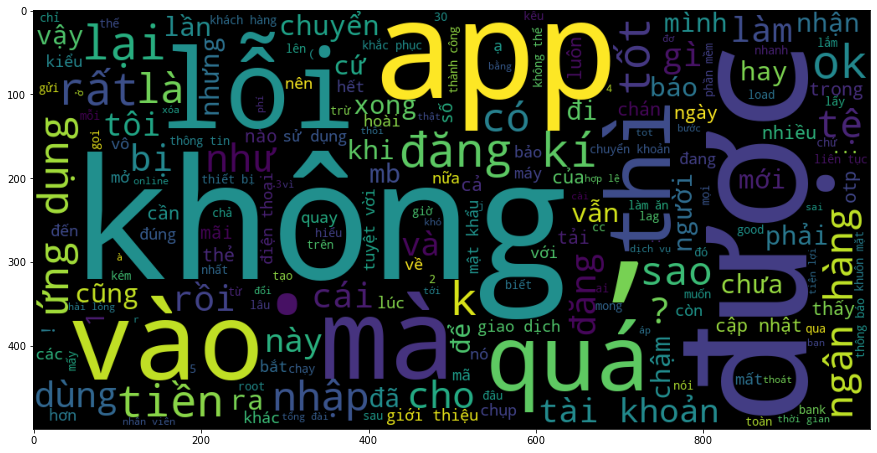

In [24]:
wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(words)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)

Nhận xét: Ngoài các stopword, nhóm thấy rằng hầu hết là các bình luận tiêu cực. Từ khóa xuất hiên nhiều nhất là `không`, tiếp theo là các từ khóa không phải stopword là `đăng ký`, `app`, `lỗi`, `tệ`, ... Có vẻ như MB phải trừ lương đội ngũ IT đây :D

### Câu hỏi 2: Tìm hiểu ảnh hưởng của câu từ đến rating?

Để trả lời cho câu hỏi này, bạn sẽ làm như sau:
- Bước 1: Tiền xử lý, nối từ, chuyển 1 số từ sai thành từ đúng, chuyển chữ hoa thành chữ thường.
- Bước 2: Tìm ra 10 tử được dùng nhiều nhất ứng với từng rating từ 1 --> 5
- Bước 3: Xem xét 10 từ đó

Code bước 1 và 2. 

In [37]:
S = [dict() for i in range(5)]
content_clone = copy.deepcopy(df_review)
content_clone['content'] = content_clone['content'].str.lower()
content = content_clone['content'].to_numpy()
rate = content_clone['rate'].to_numpy()

for Str, r in zip(content_clone['content'], content_clone['rate']):
    true_sentence = convert_to_true_sentence(Str, list_error_word, list_true_word)
    for word in word_tokenize(true_sentence):
        word = word.lower()
        if word in ['.', ',', ';', '!', '-', '_']:
            continue
        if word in S[r-1].keys():
            S[r-1][word] += 1
        else:
            S[r-1][word] = 1
    
S = [sorted([(value,key) for (key,value) in S[i].items()])[-10:] for i in range(5)]

In [38]:
print("10 từ được dùng nhiều nhất với rating 1")
for x in S[0]:
    print(x)

10 từ được dùng nhiều nhất với rating 1
(1215, 'lại')
(1227, 'đăng kí')
(1314, 'thì')
(1496, 'quá')
(1496, 'vào')
(1577, 'lỗi')
(1700, 'mà')
(2485, 'app')
(2873, 'được')
(3666, 'không')


In [39]:
print("10 từ được dùng nhiều nhất với rating 2")
for x in S[1]:
    print(x)

10 từ được dùng nhiều nhất với rating 2
(133, 'quá')
(146, 'thì')
(147, 'k')
(159, 'lại')
(184, 'lỗi')
(189, 'vào')
(197, 'mà')
(275, 'app')
(376, 'được')
(419, 'không')


In [40]:
print("10 từ được dùng nhiều nhất với rating 3")
for x in S[2]:
    print(x)

10 từ được dùng nhiều nhất với rating 3
(114, 'lỗi')
(116, 'đăng kí')
(117, 'sao')
(124, 'có')
(128, 'vào')
(143, 'lại')
(144, 'mà')
(220, 'app')
(324, 'được')
(336, 'không')


In [41]:
print("10 từ được dùng nhiều nhất với rating 4")
for x in S[3]:
    print(x)

10 từ được dùng nhiều nhất với rating 4
(59, 'cho')
(66, 'có')
(66, 'lỗi')
(67, 'rất')
(70, 'vào')
(83, 'tốt')
(90, 'app')
(114, 'ok')
(137, 'được')
(156, 'không')


In [42]:
print("10 từ được dùng nhiều nhất với rating 5")
for x in S[4]:
    print(x)

10 từ được dùng nhiều nhất với rating 5
(213, 'và')
(224, 'tiền')
(255, 'ứng dụng')
(311, 'tuyệt vời')
(312, 'app')
(334, 'không')
(336, 'được')
(884, 'rất')
(1163, 'tốt')
(1364, 'ok')


Nhận xét (bước 3): với các rating từ 1-->4, các từ được dùng nhiều nhất tương đối giống nhau. Với rating 4 và 5 xuất hiện nhiều từ mang nghĩa tích cực như 'ok', 'tốt' và 'tuyệt vời' (đặc biệt rating 5).

### Câu hỏi 3: Rating thay đổi như thế nào theo tháng?

#### Ngày đầu tiên và ngày cuối cùng được review?

In [43]:
begin_date = df_review['date_time'].min() 
end_date = df_review['date_time'].max()
print("min date: ", begin_date)
print("max date: ", end_date)

min date:  2021-02-07 23:33:00
max date:  2021-12-16 17:36:00


#### Số lượng reviews thay đổi thế nào theo tháng?

    Month  rate
0       2   316
1       3   919
2       4   945
3       5   762
4       6  1260
5       7  1605
6       8  1747
7       9  1408
8      10  1632
9      11  2505
10     12   800


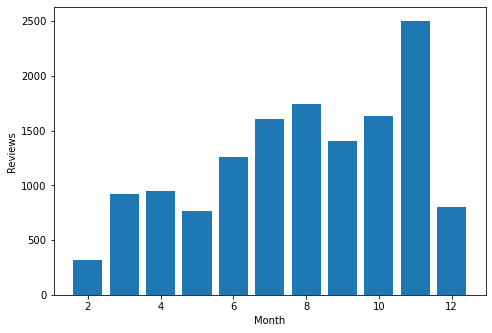

In [44]:
df = df_review[['rate', 'Month']]
df = df.groupby("Month").count().reset_index()

print(df)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_xlabel("Month")
ax.set_ylabel("Reviews")
ax.bar(df['Month'], df['rate'])
plt.show()

Số rating có xu hướng tăng từ từ đến cuối năm, tăng mạnh và đạt đỉnh ở tháng 11 và giảm mạnh ở tháng 12. Việc giảm mạnh ở tháng 12 có thể vì ngày cuối cùng review là 16/12, chỉ mới nữa tháng 12.

#### Rating thay đổi thế nào theo tháng?

    Month      rate
0       2  2.895570
1       3  2.958651
2       4  2.953439
3       5  2.822835
4       6  3.153968
5       7  2.532710
6       8  2.586720
7       9  3.128551
8      10  3.166054
9      11  2.163273
10     12  2.933750
Rating mean:  2.7679689186272394


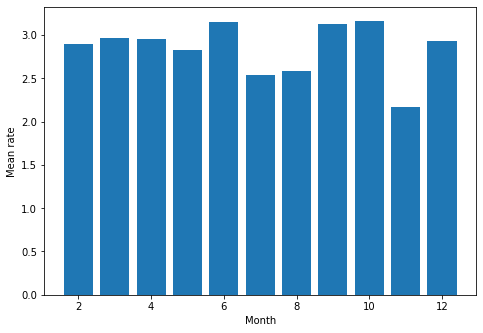

In [45]:
df = df_review[['rate', 'Month']]
df = df.groupby("Month").mean().reset_index()

print(df)
print("Rating mean: ", df_review['rate'].mean())
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_xlabel("Month")
ax.set_ylabel("Mean rate")
ax.bar(df['Month'], df['rate'])
plt.show()

Nhìn chung, rating thay đổi không nhiều, gần mức trung bình 2.76. Tháng 11 tuy có nhiều review nhất nhưng lại có rating trung bình thấp nhất: 2.16

### Câu hỏi 4: Tìm hiểu đánh giá của người dùng về một số tính năng ? 

Để trả lời cho câu hỏi này, bạn sẽ làm như sau:
- Bước 1: Chuyển hết các content sang dạng chữ thường (lower)
- Bước 2: Liệt kê danh sách các cách viết tên tính năng mà người dùng có thể viết review (ví dụ tính năng 'đăng ký' có thể được người dùng viết là 'đăng kí', 'đk', 'dk',...)
- Bước 3: Lọc ra các content có chứa từ khóa (tên tính năng) tìm thấy ở bước 1
- Bước 4: Thực hiện đếm số lượng theo rating và vẽ biểu đồ

Code bước 1. 

In [46]:
#Chuyển hết content sang dạng chữ thường
df_clone = copy.deepcopy(df_review)
df_clone['content'] = df_clone['content'].str.lower()

Code bước 2. 

In [47]:
list_char = ['i','ì','í','ị','ỉ','y','ỳ','ý','ỵ','ỷ']
#Liệt kê danh sách các cách viết tên tính năng
def generateFeatureName(name):
    list_name = [name];
    list_name.append(unidecode.unidecode(name))
    list_split = name.split();
    last_char = name[len(name)-1]
    if(len(list_split) > 1):
        first_char = list_split[0][0]
        list_name.append(first_char+list_split[1])
        list_name.append(first_char+unidecode.unidecode(list_split[1]))
        list_name.append(unidecode.unidecode(first_char)+unidecode.unidecode(list_split[1]))
        list_name.append(first_char+list_split[1][0])
        list_name.append(first_char+unidecode.unidecode(list_split[1][0]))
        list_name.append(unidecode.unidecode(first_char)+unidecode.unidecode(list_split[1][0]))
        list_name.append(unidecode.unidecode(first_char)+list_split[1][0])
    if(unidecode.unidecode(last_char) == 'i' or unidecode.unidecode(last_char) == 'i'):
        index_ofi = list_char.index(name[len(name)-1]);
        if(list_char.index(name[len(name)-1])<5):
            namei = copy.deepcopy(name);
            name_new = namei[0:(len(namei) - 1)] + list_char[index_ofi+5]
            list_name.append(name_new)
            list_name.append(unidecode.unidecode(name_new))
            list_split = name_new.split();
            last_char = name_new[len(name_new)-1]
            if(len(list_split) > 1):
                first_char = list_split[0][0]
                list_name.append(first_char+list_split[1])
                list_name.append(first_char+unidecode.unidecode(list_split[1]))
                list_name.append(unidecode.unidecode(first_char)+unidecode.unidecode(list_split[1]))
        if(list_char.index(name[len(name)-1])>=5):
            namei = copy.deepcopy(name);
            name_new = namei[0:(len(namei) - 1)] + list_char[index_ofi-5]
            list_name.append(name_new)
            list_name.append(unidecode.unidecode(name_new))
            list_split = name_new.split();
            last_char = name_new[len(name_new)-1]
            if(len(list_split) > 1):
                first_char = list_split[0][0]
                list_name.append(first_char+list_split[1])
                list_name.append(first_char+unidecode.unidecode(list_split[1]))
                list_name.append(unidecode.unidecode(first_char)+unidecode.unidecode(list_split[1]))
    return set(list_name)

list_otp = generateFeatureName('otp')
list_dk = generateFeatureName('đăng kí')
list_gt = generateFeatureName('giới thiệu')
list_cn = generateFeatureName('cập nhật')
list_dn = generateFeatureName('đăng nhập')
list_ct = generateFeatureName('chuyển tiền')

Code bước 3. 

In [48]:
#Lọc các content chứa từ khóa
def filterConstrainKeyword(list_keyword):
    df_result = pd.DataFrame()
    for keyword in list_keyword:
        df_filter = df_clone[df_clone['content'].str.contains(keyword, regex=False)]
        df_result = df_result.append(df_filter)
    df_result = df_result.drop_duplicates()
    return df_result

df_filter_dk = filterConstrainKeyword(list_dk)
df_filter_dn = filterConstrainKeyword(list_dn)
df_filter_gt = filterConstrainKeyword(list_gt)
df_filter_otp = filterConstrainKeyword(list_otp)
df_filter_cn = filterConstrainKeyword(list_cn)
df_filter_ct = filterConstrainKeyword(list_ct)

Code bước 4 : Vẽ biểu đồ theo rate 

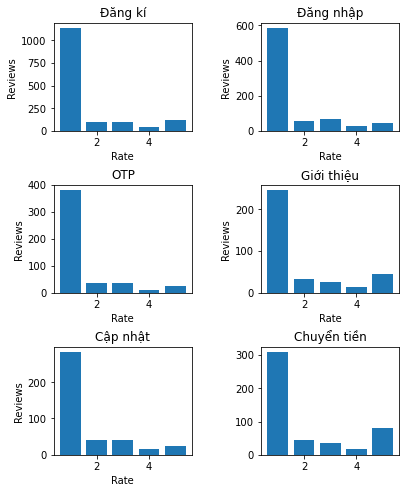

In [49]:
fig, ((ax1, ax2), (ax3, ax4), (ax5,ax6)) = plt.subplots(3, 2)

rate_count = df_filter_dk['rate'].value_counts()
rate_count = rate_count.sort_index()
ax1.set_xlabel("Rate")
ax1.set_ylabel("Reviews")
ax1.bar(rate_count.index,rate_count)
ax1.set_title('Đăng kí')

rate_count = df_filter_dn['rate'].value_counts()
rate_count = rate_count.sort_index()
ax2.set_xlabel("Rate")
ax2.set_ylabel("Reviews")
ax2.bar(rate_count.index,rate_count)
ax2.set_title('Đăng nhập')

rate_count = df_filter_otp['rate'].value_counts()
rate_count = rate_count.sort_index()
ax3.set_xlabel("Rate")
ax3.set_ylabel("Reviews")
ax3.bar(rate_count.index,rate_count)
ax3.set_title('OTP')

rate_count = df_filter_gt['rate'].value_counts()
rate_count = rate_count.sort_index()
ax4.set_xlabel("Rate")
ax4.set_ylabel("Reviews")
ax4.bar(rate_count.index,rate_count)
ax4.set_title('Giới thiệu')

rate_count = df_filter_cn['rate'].value_counts()
rate_count = rate_count.sort_index()
ax5.set_xlabel("Rate")
ax5.set_ylabel("Reviews")
ax5.bar(rate_count.index,rate_count)
ax5.set_title('Cập nhật')

rate_count = df_filter_ct['rate'].value_counts()
rate_count = rate_count.sort_index()

ax6.bar(rate_count.index,rate_count)
ax6.set_title('Chuyển tiền')
#Set Spacing
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=1.6, 
                    wspace=0.5, 
                    hspace=0.5)
plt.show()

**Nhận xét**: Em thực hiện khảo sát đánh giá của các bình luận có nhắc đến "đăng ký", "otp", "giới thiệu", "cập nhật" và nhận thấy các bình luận này đa số là đánh giá 1 sao.
- **Đăng kí**: đây là tính năng quan trọng nhất của mọi app vì tính năng này sẽ là tính năng đầu tiên mà người dùng mới tiếp cận vào 1 app, có ảnh hưởng cao đến việc user có tiếp tục với app của mình không, vậy nên với 1000 bài review nhắc về đăng kí là phàn nàn (đánh giá 1 sao) thì em nghĩ MB Bank cần xem xét về tính năng này của họ để cải thiện cảm nhận của người dùng về app của mình
- **Đăng nhập**: có khoảng hơn 500 bài review nhắc về đăng nhập đánh giá 1 sao thì em nghĩ MB Bank cần kiểm thử lại tính năng đăng nhập của app
- **OTP**: là một bước để người dùng xác thực khi đăng kí, với khoảng gần 400 lượt rate 1 sao (chiếm khoảng hơn 80%) có nhắc tới OTP, em nghĩ đây là 1 phần nguyên nhân mà người dùng rate 1 sao nhiều ở tính năng đăng kí bên trên, MB Bank có thể suy nghĩ về việc cải thiện tính năng đăng kí với việc xem xét lại OTP
- **Giới thiệu**: là tính năng mới của MB Bank tạo ra để mở rộng độ phổ biến của app, khi 1 người dùng giới thiệu thành công cho người khác sẽ được tặng tiền vào tài khoản. Vậy nhưng có khoảng 300 review nhắc tới "giới thiệu" với hơn 200 review đánh 1 sao, phải chăng người dùng đã giới thiệu cho bạn bè nhưng không được cộng tiền? Đây cũng là 1 bug mà MB Bank cần xem xét và fix bug để người dùng có thêm động lực giới thiệu nhiều bạn bè khác :D, bên cạnh đó cũng có 1 lượng người đánh giá 5 sao cho tính năng này (tỉ lệ cao hơn các tính năng đăng kí, OTP), cho thấy tính năng mới này được hưởng ứng, nên MB Bank cần xem xét fix bug được kể trên
- **Cập nhật**: Các app đều có các đợt cập nhật để thêm tính năng mới hoặc fix bug, nhưng khoảng hơn 250 lượt đánh giá 1 sao có nhắc tới cập nhật, có lẽ sau mỗi đợt cập nhật app có 1 số bug khiến người dùng khó chịu mà MB Bank cần đọc các review này để xem lỗi nào để các lần cập nhật sau không bị lại
- **Chuyển tiền**: Vì đây là 1 app của ngân hàng nên vấn đề chuyển tiền là rất quan trọng, cần giảm số lượng bug liên quan đến chuyển tiền đến mức thấp nhất có thể, nhưng ở đây em đang thấy với khoảng 300 lượt vote 1 sao có nhắc đến chuyển tiền... hmm có vẻ nhóm IT cần cải thiện tính năng này càng sớm càng tốt

## Nhìn lại quá trình làm đồ án

### Nguyễn Tuấn Anh

1. Những khó khăn <br/>
- Khó khăn 1: Dữ liệu do em crawl từ Google Play về nên ở giai đoạn đầu em gặp khá nhiều khó khăn trong khâu này
- Khó khăn 2: Vì các content là dữ liệu thật do người dùng nhận xét, nên rất nhiều từ sai chính tả hoặc viết tắt, nên giai đoạn tiền xử lý chính tả (chuyển các error word sang true word) tốn khá nhiều thời gian của em.
2. Những điều học được <br/>
- Điều 1: Hiểu rõ hơn về pandas, numpy, các thư viện mới như unicode, wordcloud, untherthesea trong việc xử lý string
- Điều 2: Em học thêm về cách crawl dữ liệu thực và xử lý JSON.


### Chương Việt Hoàng

1. Những khó khăn <br/>
- Khó khăn 1: Dữ liệu dạng string có nhiều lỗi, sai chính tả --> cần tiền xử lính tốt mới cho kết quả chính xác.
- Khó khăn 2: Việc tiền xử lý string khá khó, vẫn không clean sạch hết các content.
2. Những điều học được <br/>
- Điều 1: Hiểu rõ hơn về pandas, numpy trong việc xử lý string
- Điều 2: Hiểu thêm về việc tiền xử lý string qua các thư viện (như unicode, wordcloud, underthesea) cũng như cách làm của bạn Trinh.


### Lê Thị Tuyết Trinh

1. Những khó khăn <br/>
- Dữ liệu của nhóm chủ yếu tập trung vào cột content, rate và date_time, trong đó content (dữ liệu text là các nhận xét của người dùng) nên việc xử lý dữ liệu với content khiến em cảm thấy khá khó để xác định được nên đặt câu hỏi như nào cho ý nghĩa và có thể xử lý được
- Khó khăn về thời gian, do đồ án thực hiện vào cuối kỳ, em và các bạn trong nhóm đang thực tập và làm báo cáo các môn khác, nên việc họp định kỳ hoặc dành nhiều thời gian cho bài cuối kỳ là không nhiều :<< chúng em cũng cố gắng trao đổi trên nhóm chat chung để hỗ trợ nhau làm bài
- Em chưa được làm việc nhiều với jupyter notebook và các thư viện trong python cũng như chưa học môn nhập môn khoa học dữ liệu, nên có nhiều lúc em bị bí không biết nên xử lý như thế nào cho ổn và code clean :<<
2. Những điều học được <br/>
- Em được biết thêm về một số thư viện khác (như unicode, wordcloud, underthesea) và được biết rõ hơn về pandas
- Những kiến thức thầy dạy trên lớp về python, về git, ... đều rất hữu ích cho em trong đồ án này, và có được suy nghĩ về việc đặt câu hỏi ý nghĩa như thế nào cho dataset có được


### Nếu có thêm thời gian

- Nhóm em sẽ xử lý sâu hơn về câu hỏi có thể chia bình luận thành các chủ đề được không và có thể tìm hiểu KMean để tìm hiểu về nó.
- Nhóm có thể dùng các model NLP mạnh hơn train trên dataset lớn để clean dữ liệu (sửa những từ sai chính tả)